In [16]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(0)
pd.set_option('display.max_columns', None)

In [ ]:
# Technical indicators
trend_indicators = ["DMN_5", "DMN_10", "ADX_5", "ADX_10", "DMP_5"]
oscillators =["MACD_8_21_5", "STOCHd_7_3_3", "RSI_7"]
moving_averages = ["MA_20", "KAMA_3_2_10", "EMA_15", "MA_10"]
volatility_indicators = ["Bollinger_Lower", "Bollinger_Upper"]
other_indicators = []
technical_indicators = trend_indicators + oscillators + moving_averages + volatility_indicators + other_indicators

# LOB specific indicators
mid_price_indicators = ["std_mid_price", "weighted_mid_price_variation", "mean_mid_price_variation"]
bid_ask_prices_indicators = ["std_spread", "mean_spread"]
volume_indicators = ["total_bid_volume", "total_ask_volume", "std_best_bid_size", "std_best_ask_size"]
orders_indicators = ["mean_order_book_imbalance", "order_book_imbalance_5s", "order_flow_5s", "last_order_book_imbalance", "total_net_order_flow"]
lob_indicators = mid_price_indicators + bid_ask_prices_indicators + volume_indicators + orders_indicators

time_indicators = ['time_since_open']

# Feature list
features =  lob_indicators + technical_indicators + time_indicators

In [ ]:
sampling_rate = "200ms"
prediction_column = "mean_mid_price_variation_class"
batch_size = 16
look_back = 8

In [19]:
from tf_preprocessing import process_and_combine_data

start_date = "2024-10-08"
end_date = "2024-10-09"

all_data = process_and_combine_data(start_date, end_date, data_folder="../AAPL_data", sampling_rate=sampling_rate)

print(all_data.columns)

all_data.head()

Index(['mid_price_first', 'mid_price_last', 'mid_price_high', 'mid_price_low',
       'mid_price_mean', 'std_mid_price', 'weighted_mid_price_first',
       'weighted_mid_price_last', 'weighted_mid_price_mean', 'last_spread',
       'mean_spread', 'std_spread', 'last_best_bid_price',
       'mean_best_bid_price', 'last_best_ask_price', 'mean_best_ask_price',
       'last_best_bid_size', 'mean_best_bid_size', 'std_best_bid_size',
       'last_best_ask_size', 'mean_best_ask_size', 'std_best_ask_size',
       'mean_second_ask_price', 'mean_second_bid_price', 'mid_price_variation',
       'mid_price_variation_class', 'mean_mid_price_variation',
       'mean_mid_price_variation_class',
       'next_5_mean_mid_price_variation_class', 'weighted_mid_price_variation',
       'weighted_mid_price_variation_class', 'total_bid_volume',
       'total_ask_volume', 'mean_order_book_imbalance',
       'last_order_book_imbalance', 'total_net_order_flow', 'num_added_orders',
       'num_canceled_orders', 

,mid_price_first,mid_price_last,mid_price_high,mid_price_low,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,next_5_mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1,time_since_open,is_monday,is_friday
ts_recv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-08 09:30:03-04:00,223.780,223.780,223.780,223.775,223.779286,0.001816,223.751429,223.748889,223.752229,0.08,0.078571,0.003631,223.74,223.740000,223.82,223.818571,25.0,25.000000,0.000000,200.0,158.928571,58.512936,223.828571,223.730000,0.000000,1.0,-0.000003,0,0,-0.000011,0,0,50,-0.723107,-0.777778,-175,5,3,6,-0.570397,-165.0,0.0,50.0,0.0,0.0,223.76,223.77,223.785,223.76,77.996684,69.890047,63.595211,7.209690,10.013808,75.259588,70.702165,0.0,57.142857,0.015,0.060,0.060,0.060,0.000,0.020,21.428571,18.907563,-0.002395,18.147518,-0.11250,223.926130,223.821321,223.791584,223.880872,224.011336,0.005000,7.500000e-03,-0.001,-0.025833,224.356133,223.666540,0.689593,0.173733,0.000,0.000,0.015,0.015,0.005,0.000,3.0,0,0
2024-10-08 09:30:03.200000-04:00,223.805,223.790,223.815,223.775,223.788333,0.012672,223.790472,223.758116,223.770780,0.10,0.070476,0.022191,223.74,223.753095,223.84,223.823571,50.0,24.880952,11.223239,226.0,112.357143,82.880997,223.833571,223.732619,-0.000067,0.0,-0.000074,0,0,-0.000145,0,2,0,-0.641221,-0.637681,-176,17,16,9,-0.680169,-140.2,25.0,101.0,0.0,0.0,223.81,223.82,223.820,223.79,70.188602,67.195154,62.899180,25.521351,17.646167,58.095274,63.738030,0.0,42.857143,0.030,0.085,0.085,0.085,0.010,0.010,32.558140,23.877923,0.002668,21.774579,-0.08225,223.908906,223.804496,223.790283,223.853768,223.985253,-0.005000,7.105427e-15,0.003,-0.003333,224.314296,223.656210,0.658086,0.163675,-0.015,0.000,0.000,0.015,0.040,0.000,3.2,0,0
2024-10-08 09:30:03.600000-04:00,223.775,223.795,223.805,223.775,223.793529,0.009315,223.766515,223.793585,223.787938,0.05,0.060000,0.010000,223.77,223.763529,223.82,223.823529,25.0,44.117647,44.659661,28.0,77.647059,83.410087,223.835882,223.752353,0.000089,2.0,0.000083,1,0,0.000121,1,100,253,-0.271014,-0.056604,-3,10,6,1,0.039133,-35.8,-25.0,-22.0,0.0,0.0,223.81,223.81,223.810,223.81,63.942137,64.885246,62.272753,21.025754,16.307591,47.861764,58.903087,0.0,28.571429,0.000,0.010,0.055,0.055,0.040,0.040,78.947368,44.311360,0.007096,24.030130,-0.04625,223.894484,223.793543,223.791532,223.827121,223.959213,0.001667,1.250000e-03,0.004,0.005833,224.261290,223.657136,0.604155,0.150425,0.020,-0.015,0.000,0.000,0.030,0.010,3.6,0,0
2024-10-08 09:30:03.800000-04:00,223.795,223.785,223.820,223.785,223.803684,0.013145,223.793585,223.747500,223.803605,0.09,0.036140,0.019888,223.74,223.785614,223.83,223.821754,25.0,138.403509,94.081815,275.0,121.421053,74.140780,223.831754,223.768070,-0.000045,0.0,0.000039,1,1,-0.000206,0,182,-28,0.065429,-0.833333,-250,22,22,13,0.052400,-51.2,0.0,247.0,0.0,0.0,223.77,223.81,223.820,223.77,55.115466,6

In [21]:
all_data.mean_mid_price_variation_class.value_counts()

mean_mid_price_variation_class
1    23835
0    17145
Name: count, dtype: int64

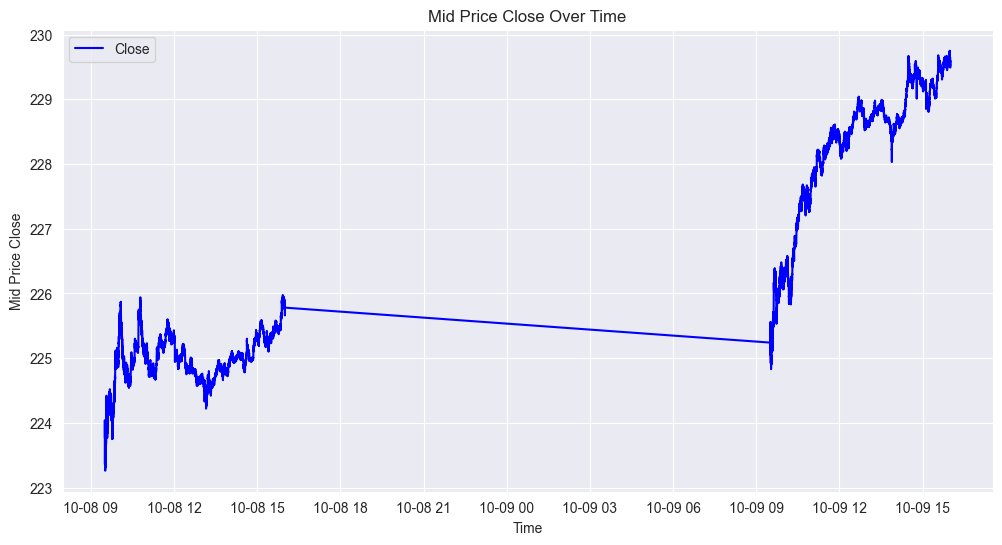

In [23]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data["trade_close"], label="Close", color="blue")
plt.xlabel("Time")
plt.ylabel("Mid Price Close")
plt.title("Mid Price Close Over Time")
plt.legend()
plt.show()

In [24]:
# Data Splitting
train_size = int(len(all_data) * 0.7)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size:train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size:, :]

In [25]:
from keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

class TimeSeriesScalerGenerator(Sequence):
    def __init__(self, data, target, features, look_back, batch_size, **kwargs):
        super().__init__(**kwargs)  # Call the superclass constructor with **kwargs

        self.data = data[features].values
        self.targets = data[target].values.astype(int)
        self.features = features
        self.look_back = look_back
        self.batch_size = batch_size
        self.scaler = MinMaxScaler(feature_range=(0, 1))

        # Store true labels for the entire dataset
        self.true_labels = self.targets[look_back:]

        # Compute valid indices for sequence extraction
        self.indices = np.arange(len(self.data) - self.look_back)

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        """Generates one batch of data."""
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]

        # Extract sequences and labels
        batch_data = np.array([self.data[i : i + self.look_back] for i in batch_indices])
        batch_labels = np.array([self.targets[i + self.look_back] for i in batch_indices])

        # Normalize each sequence individually
        batch_data = np.array([self.scaler.fit_transform(seq) for seq in batch_data])

        return batch_data, batch_labels

    def on_epoch_end(self):
        """Called at the end of each epoch."""
        pass

In [26]:
# Comment/Uncomment to scale by batch
train_gen = TimeSeriesScalerGenerator(train_df, prediction_column, features, look_back=look_back, batch_size=batch_size)
val_gen = TimeSeriesScalerGenerator(val_df, prediction_column, features, look_back=look_back, batch_size=batch_size)
test_gen = TimeSeriesScalerGenerator(test_df, prediction_column, features, look_back=look_back, batch_size=batch_size)

In [27]:
# # Comment/Uncomment to use scale all training data at once
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# # Fit scalers on training data only
# minmax_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_df[features])

# # Apply scalers to training, validation, and test sets
# # VERIFY if the scaled values are totally unreadable or still manageable
# train_scaled = minmax_scaler.transform(train_df[features])
# val_scaled = minmax_scaler.transform(val_df[features])
# test_scaled = minmax_scaler.transform(test_df[features])

# # Extract targets separately
# train_target = train_df[prediction_column].values
# val_target = val_df[prediction_column].values
# test_target = test_df[prediction_column].values

# # Create generators with pre-scaled data
# train_gen = TimeSeriesGenerator(train_scaled, train_target, look_back=look_back, batch_size=batch_size)
# val_gen = TimeSeriesGenerator(val_scaled, val_target, look_back=look_back, batch_size=batch_size)
# test_gen = TimeSeriesGenerator(test_scaled, test_target, look_back=look_back, batch_size=batch_size)

In [28]:
from keras import layers, models, optimizers

num_classes = len(np.unique(all_data[prediction_column]))

def create_model():
    input_size = len(features)
    inputs = layers.Input(shape=(look_back, input_size))

    # First LSTM layer
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Second LSTM layer
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Dense layers
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

num_models = 1
epochs = 10
all_predictions = []

for i in range(num_models):
    print(f"Training model {i + 1}/{num_models}")
    tf.random.set_seed(i + 1)
    model = create_model()
    optimizer = optimizers.Adam(learning_rate=0.001)
    # optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    
    model.fit(train_gen, validation_data=val_gen, epochs=epochs)
    
    predictions = model.predict(test_gen)
    all_predictions.append(predictions)


Training model 1/1
Epoch 1/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5428 - loss: 0.7504 - val_accuracy: 0.5732 - val_loss: 0.7204
Epoch 2/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.5840 - loss: 0.6786 - val_accuracy: 0.5732 - val_loss: 0.6997
Epoch 3/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5811 - loss: 0.6771 - val_accuracy: 0.5732 - val_loss: 0.6775
Epoch 4/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.5858 - loss: 0.6740 - val_accuracy: 0.5745 - val_loss: 0.6763
Epoch 5/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.5875 - loss: 0.6742 - val_accuracy: 0.5343 - val_loss: 0.7069
Epoch 6/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.5939 - loss: 0.6699 - val_accuracy: 0.5456 - val_loss: 0.6939
Epoch 7/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.6088 - loss: 0.6609 - val_accuracy: 0.5527 - val_loss: 0.7050
Epoch 8/10
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - 

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def plot_evaluation_metrics(y_true, y_pred, log_probabilities):
    probabilities = np.exp(log_probabilities)
    unique_classes = np.unique(y_true)
    num_classes = len(unique_classes)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    class_labels = ["Down (0)", "Up (1)"] if num_classes == 2 else ["Down (0)", "Constant (1)", "Up (2)"]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[0],
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Histogram of Predicted Probabilities
    for i, class_label in enumerate(class_labels):
        sns.histplot(
            probabilities[y_true == unique_classes[i]][:, i], bins=30, label=class_label, ax=axes[1]
        )
    axes[1].set_title("Probability Distribution")
    axes[1].set_xlabel("Predicted Probability")
    axes[1].legend()

    # Scatter Plot of Predictions
    scatter = sns.scatterplot(
        x=np.arange(len(probabilities)),
        y=probabilities.max(axis=1),
        hue=y_true,
        palette={0: "red", 1: "blue"} if num_classes == 2 else {0: "red", 1: "blue", 2: "green"},
        alpha=0.7,
        ax=axes[2],
    )
    axes[2].set_title("Scatter Plot of Predictions")
    axes[2].set_xlabel("Sample Index")
    axes[2].set_ylabel("Max Predicted Probability")

    handles, labels = scatter.get_legend_handles_labels()
    axes[2].legend(handles, class_labels, title="True Class")

    axes[2].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))

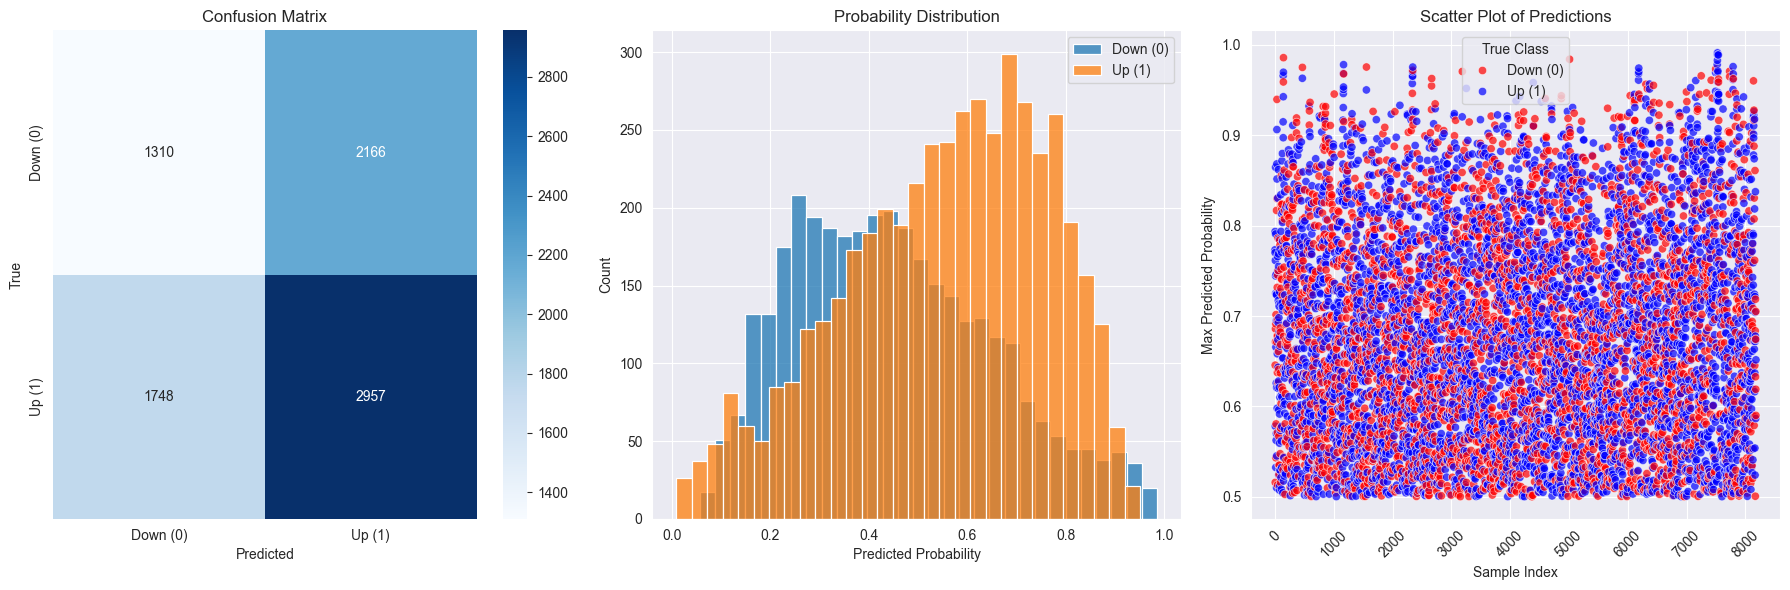

Accuracy: 0.5216
              precision    recall  f1-score   support

           0       0.43      0.38      0.40      3476
           1       0.58      0.63      0.60      4705

    accuracy                           0.52      8181
   macro avg       0.50      0.50      0.50      8181
weighted avg       0.51      0.52      0.52      8181



In [30]:
# Convert predictions to class labels
all_predictions = np.array(all_predictions)
predicted_classes = np.argmax(all_predictions, axis=-1)

# Majority voting
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predicted_classes)

# Compute log probabilities for evaluation
log_probabilities = np.log(np.mean(all_predictions, axis=0))

# Evaluate the final predictions
y_true = test_gen.true_labels  # Assuming test_gen has the true labels

# Ensure log_probabilities shape matches the number of classes in y_true
if num_classes == 2:
    log_probabilities = log_probabilities[:, :2]

plot_evaluation_metrics(y_true, final_predictions, log_probabilities)

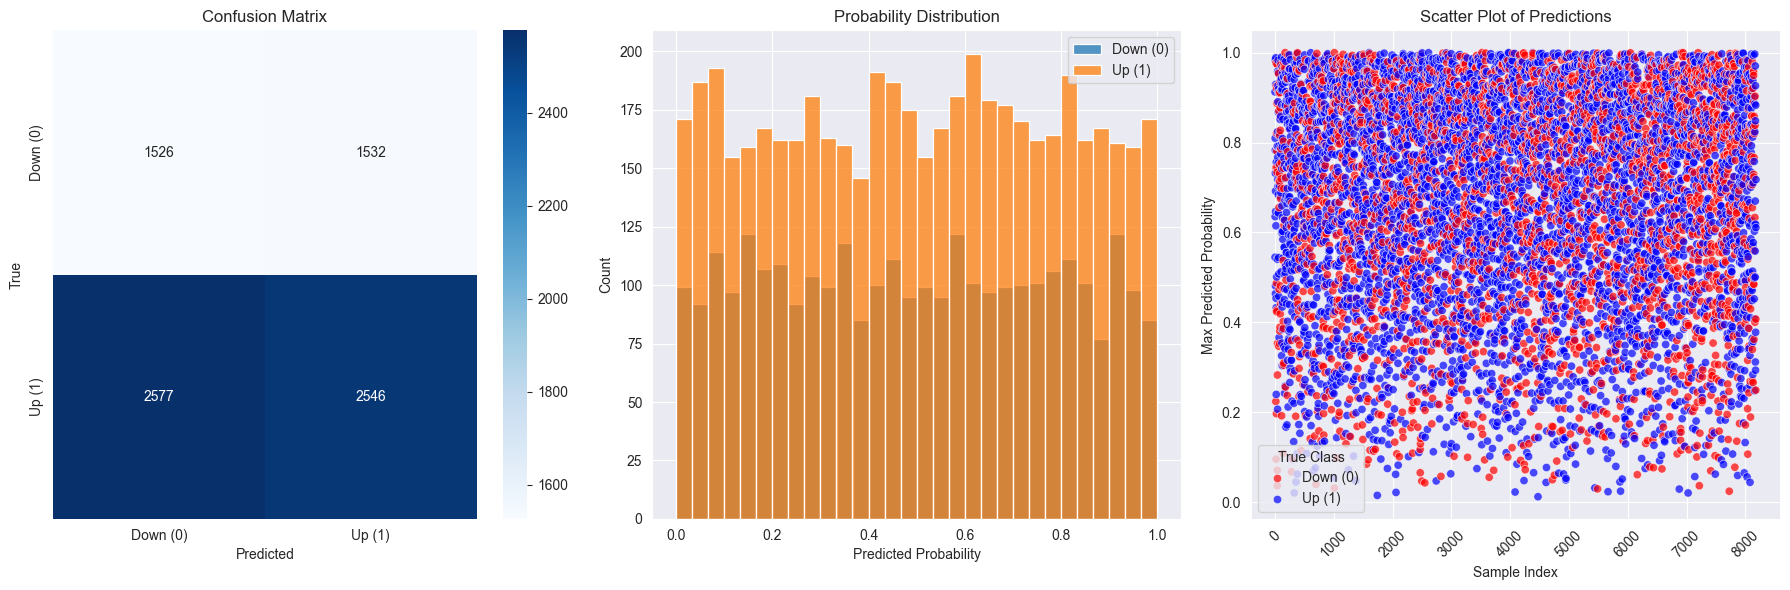

Accuracy: 0.4977
              precision    recall  f1-score   support

           0       0.37      0.50      0.43      3058
           1       0.62      0.50      0.55      5123

    accuracy                           0.50      8181
   macro avg       0.50      0.50      0.49      8181
weighted avg       0.53      0.50      0.51      8181



In [31]:
# Determine the number of classes
num_classes = len(np.unique(final_predictions))

# Implement a random strategy
random_y_pred = np.random.randint(0, num_classes, size=len(final_predictions))
random_log_probabilities = np.log(np.random.rand(len(final_predictions), num_classes))

# Plot evaluation metrics for the random strategy
plot_evaluation_metrics(final_predictions, random_y_pred, random_log_probabilities)